In [71]:
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

import torch
from transformers import GPT2Tokenizer
from datasets import load_dataset
from torch.utils.data import Dataset

from mingpt.model import GPT
from mingpt.trainer import Trainer
from mingpt.utils import set_seed

In [72]:
# set model hyperparameters
select_mingpt = True
model_architecture = 'gpt2'
device = 'cpu'
set_seed(42)

Dataset

In [73]:
# load data
dataset = load_dataset("togethercomputer/RedPajama-Data-1T-Sample", "plain_text", cache_dir="datasets")["train"]

Found cached dataset red_pajama-data-1_t-sample (c:/Users/dalli/source/repos/CS674/lab2/minGPT/datasets/togethercomputer___red_pajama-data-1_t-sample/plain_text/1.0.0/6ea3bc8ec2e84ec6d2df1930942e9028ace8c5b9d9143823cf911c50bbd92039)
100%|██████████| 1/1 [00:05<00:00,  5.41s/it]


In [91]:
# dataset class
new_tokens = [f'<new_id_{i}>' for i in range(300)]

class RedPajama(Dataset):
    def __init__(self, data, max_length=1024, ul2=False):
        self.data = data
        self.max_length = max_length - 1

        # CHANGE implement UL2
        self.tokenizer = GPT2Tokenizer.from_pretrained(model_architecture)
        self.tokenizer.add_tokens([f'new_id_{i}' for i in range(300)])
        self.tokenizer.add_tokens(['[S2S]', '[NLU]', '[NLG]'])
        self.tokenizer.pad_token_id = 50256
        
        self.vocab_size = len(self.tokenizer)
        self.token_dict = {'s': ['[S2S]', self.s_denoiser], 'r': ['[NLU]', self.r_denoiser], 'x': ['[NLG]', self.x_denoiser]}
        self.use_ul2 = ul2

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # load and tokenize the text
        text = self.data[idx]['text']

        if self.use_ul2:
            # choose a denoiser
            did, denoiser = self.token_dict[np.random.choice(['s', 'r', 'x'], size=1, p=[0.5, 0.25, 0.25])[0]]

            # update text and encode, then denoise
            text = did + " " + text
            tokens = self.tokenizer.encode(text, 
                                        add_special_tokens=True, 
                                        max_length=self.max_length, 
                                        truncation=True, 
                                        return_tensors='pt', 
                                        padding=True)
            return denoiser(tokens, self.tokenizer)
        
        elif not self.use_ul2:
            tokens = self.tokenizer.encode(text, 
                                           add_special_tokens=True, 
                                           max_length=self.max_length, 
                                           truncation=True, 
                                           return_tensors='pt', 
                                           padding=True)
            
            # split and shift tokens after excluding the CLS token
            targets = tokens[:, 1:].clone()
            tokens = tokens[:, :-1]  
            return tokens, targets
        

    def s_denoiser(self, tokens, tokenizer):
        center = tokens.shape[1] // 2
        breadth = 15

        # remove tokens according to sequential denoising
        remove_idx = np.random.choice(np.arange(center - breadth, center + breadth))
        mask = tokenizer.convert_tokens_to_ids(new_tokens[0])
        removed = torch.cat((torch.tensor([[mask]]), tokens[:, remove_idx:].clone()), dim=1)
        tokens = tokens[:, :remove_idx + 1].clone()
        tokens[:, -1] = mask

        # pad tokens and return
        tokens = torch.cat((tokens, torch.tensor([[tokenizer.eos_token_id] * (self.max_length - tokens.shape[1])])), dim=1)
        removed = torch.cat((removed, torch.tensor([[tokenizer.eos_token_id] * (self.max_length - removed.shape[1])])), dim=1)
        return tokens, removed


    def r_denoiser(self, tokens, tokenizer, corrupt_rate=0.15, span=np.arange(2, 6)):
        # compute chance of corruption
        _mean = np.mean(span)
        _max = np.max(span)
        n = tokens.shape[1]
        prob = (corrupt_rate / _mean) * (1 + _max / n)
        
        # tracking variables
        removed = None
        skip_count = 0
        used_tokens = 0

        # corrupt tokens
        for i in range(1, n):
            # skip first few tokens
            if skip_count > 0:
                skip_count -= 1
                continue

            if np.random.random() < prob:
                # remove token
                mask = tokenizer.convert_tokens_to_ids(new_tokens[used_tokens])
                used_tokens += 1
                c_span = np.random.choice(span)

                # update removed
                if removed is None:
                    removed = torch.cat((torch.tensor([[mask]]), tokens[:, i:i + c_span]), dim=1)
                else:
                    removed = torch.cat((removed, torch.tensor([[mask]]), tokens[:, i:i + c_span]), dim=1)
                tokens = torch.cat((tokens[:, :i], torch.tensor([[mask]]), tokens[:, i + c_span:]), dim=1)
                skip_count = c_span

        # pad to match length
        tokens = torch.cat((tokens, torch.tensor([[tokenizer.eos_token_id] * (self.max_length - tokens.shape[1])])), dim=1)
        try:
            removed = torch.cat((removed, torch.tensor([[tokenizer.eos_token_id] * (self.max_length - removed.shape[1])])), dim=1)
        except:
            removed = torch.tensor([[tokenizer.eos_token_id] * (self.max_length)])
        return tokens, removed
    
        
    def x_denoiser(self, tokens, tokenizer, corrupt_rate=0.50, span=np.arange(2,6)):
        return self.r_denoiser(tokens, tokenizer, corrupt_rate, span)
    

# Create an instance of the custom dataset
rp_dataset = RedPajama(dataset)
rp_dataset2 = RedPajama(dataset, ul2=True)

In [75]:
# dataset class
class RedPajama(Dataset):
    def __init__(self, data, max_length=1024, ul2=False):
        # super().__init__()
        self.data = data
        self.max_length = max_length - 1
        self.tokenizer = GPT2Tokenizer.from_pretrained(model_architecture)

        # CHANGE implement UL2
        self.denoise_id = ["[S2S]", "[NLU]", "[NLG]"]
        self.tokenizer.add_tokens(self.denoise_id)
        self.extra_tokens = [f"extra_id_{i}" for i in range(300)]
        self.tokenizer.add_tokens(self.extra_tokens)
        self.denoise_functions = [self.s_denoiser, self.r_denoiser, self.x_denoiser]
        self.use_ul2 = ul2

        self.tokenizer.pad_token_id = 50256
        self.vocab_size = self.tokenizer.vocab_size

    def __len__(self):
        # return the number of data points
        return len(self.data)
    
    def __getitem__(self, idx):
        # load and tokenize the text
        text = self.data[idx]["text"]

        if self.use_ul2:
            # choose a denoise
            selected_denoiser = min(np.random.randint(0, 4) - 1, 0)
            did = self.denoise_id[selected_denoiser]
            denoiser = self.denoise_functions[selected_denoiser]

            # update text and encode, then denoise
            text = did + " " + text
            tokens = self.tokenizer.encode(text, 
                                        add_special_tokens=True, 
                                        max_length=self.max_length,
                                        truncation=True,
                                        return_tensors="pt",
                                        padding=True)
            return denoiser(tokens)

        else:
            tokens = self.tokenizer.encode(text, 
                                        add_special_tokens=True, 
                                        max_length=self.max_length,
                                        truncation=True,
                                        return_tensors="pt",
                                        padding=True)
            
            # split and shift tokens after excluding the CLS token
            targets = tokens[:, 1:].clone()
            tokens = tokens[:, :-1].clone()
            return tokens, targets
        

    def s_denoiser(self, tokens):
        center = tokens.shape[1] // 2 
        breadth = 15

        # remove tokens according to sequential denoising
        remove_idx = np.random.choice(np.arange(center - breadth, center + breadth))
        mask = self.tokenizer.convert_tokens_to_ids(self.extra_tokens[0])
        tokens = tokens[:, :remove_idx+1].clone()
        tokens[:, -1] = mask

        # pad tokens and return
        tokens = torch.cat((tokens, torch.tensor([[self.tokenizer.eos_token_id] * (self.max_length - tokens.shape[1])])), dim=1)
        removed = torch.cat((torch.tensor([[mask]]), tokens[:, remove_idx:].clone()), dim=1)
        removed = torch.cat((removed, torch.tensor([[self.tokenizer.eos_token_id] * (self.max_length - removed.shape[1])])), dim=1)

        return tokens, removed


    def r_denoiser(self, tokens, corrupt_rate=0.15, span=np.arange(2, 6)):
        # compute chance of corruption
        _mean = np.mean(span)
        _max = np.max(span)
        n = tokens.shape[1]
        prob = (corrupt_rate / _mean) * (1 + _max / n)

        # tracking variables
        removed = None
        skip_count = 0
        used_tokens = 0

        # corrupt tokens
        for i in range(n):
            # skip first few tokens
            if skip_count > 0:
                skip_count -= 1
                continue

            if np.random.random() < prob:
                # remove token
                mask = self.tokenizer.convert_tokens_to_ids(self.extra_tokens[used_tokens])
                used_tokens += 1
                c_span = np.random.choice(span)

                # update removed
                if removed is None:
                    removed = torch.tensor([[mask] * c_span])
                else:
                    removed = torch.cat((removed, torch.tensor([[mask]]), tokens[:, i:i + c_span]), dim=1)
                tokens = torch.cat((tokens[:, :i], torch.tensor([[mask]]), tokens[:, i + c_span:]), dim=1)
                skip_count = c_span

        # pad to match length
        tokens = torch.cat((tokens, torch.tensor([[self.tokenizer.eos_token_id] * (self.max_length - n)])), dim=1)
        removed = torch.cat((removed, torch.tensor([[self.tokenizer.eos_token_id] * (self.max_length - removed.shape[1])])), dim=1)

        return tokens, removed


    def x_denoiser(self, tokens, corrupt_rate=0.5, span=np.arange(2, 6)):
        return self.r_denoiser(tokens, corrupt_rate, span)
    

# rp_dataset = RedPajama(dataset)
# rp_dataset2 = RedPajama(dataset, ul2=True)

In [92]:
# set up data path
path = "./checkpoints/redpajama4"

if not os.path.exists(path):
    os.makedirs(path)
    checkpoints = os.listdir(path)
else:
    checkpoints = os.listdir(path)
checkpoints.sort()

Model

In [93]:
# set up model configurations
model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = rp_dataset.vocab_size
model_config.block_size = rp_dataset.max_length
model_config.checkpoint = None
model_config.ul2 = False

# set up model with configurations
model = GPT(model_config)


# set up model configurations
model_config2 = GPT.get_default_config()
model_config2.model_type = 'gpt-nano'
model_config2.vocab_size = rp_dataset2.vocab_size
model_config2.block_size = rp_dataset2.max_length
model_config2.checkpoint = None
model_config2.ul2 = True
model2 = GPT(model_config2)

number of parameters: 2.56M
number of parameters: 2.56M


In [94]:
# set up trainer configurations
max_iters = 3000
train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4   
train_config.max_iters = max_iters + model.iter_num if model_config.checkpoint else max_iters
train_config.num_workers = 0
train_config.checkpoint_iters = 100 
train_config.batch_size = 1
train_config.checkpoint_name = path

# set up trainer with configurations
trainer = Trainer(train_config, model, rp_dataset)


# set up trainer configurations
train_config2 = Trainer.get_default_config()
train_config2.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
train_config2.max_iters = max_iters + model2.iter_num if model_config2.checkpoint else max_iters
train_config2.num_workers = 0
train_config2.checkpoint_iters = 100 
train_config2.batch_size = 1
train_config2.checkpoint_name = path
trainer2 = Trainer(train_config2, model2, rp_dataset2)

running on device cpu
running on device cpu


In [101]:
# train model 1
def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
trainer.set_callback('on_batch_end', batch_end_callback)

trainer.run()

iter_dt 0.00ms; iter 0: train loss 10.83892
iter_dt 1045.12ms; iter 100: train loss 9.49940
iter_dt 2013.30ms; iter 200: train loss 7.41863
iter_dt 1177.18ms; iter 300: train loss 9.12020
iter_dt 233.55ms; iter 400: train loss 8.45514
iter_dt 378.42ms; iter 500: train loss 8.48204
iter_dt 1187.99ms; iter 600: train loss 6.96077
iter_dt 1795.78ms; iter 700: train loss 6.96798
iter_dt 911.10ms; iter 800: train loss 6.87461
iter_dt 196.00ms; iter 900: train loss 6.71654
iter_dt 550.00ms; iter 1000: train loss 7.41221
iter_dt 1210.00ms; iter 1100: train loss 6.93736
iter_dt 506.36ms; iter 1200: train loss 7.31240
iter_dt 330.23ms; iter 1300: train loss 6.23045
iter_dt 232.00ms; iter 1400: train loss 6.67665
iter_dt 328.00ms; iter 1500: train loss 6.72343
iter_dt 169.00ms; iter 1600: train loss 6.83319
iter_dt 721.60ms; iter 1700: train loss 6.06290
iter_dt 614.00ms; iter 1800: train loss 7.47232
iter_dt 2348.43ms; iter 1900: train loss 6.51160
iter_dt 2007.73ms; iter 2000: train loss 6.420

In [95]:
# train model 2
def batch_end_callback(trainer2):
    if trainer2.iter_num % 100 == 0:
        print(f"iter_dt {trainer2.iter_dt * 1000:.2f}ms; iter {trainer2.iter_num}: train loss {trainer2.loss.item():.5f}")
trainer2.set_callback('on_batch_end', batch_end_callback)

trainer2.run()

iter_dt 0.00ms; iter 0: train loss 10.84418
iter_dt 1228.00ms; iter 100: train loss 6.71064
iter_dt 1291.96ms; iter 200: train loss 4.71071
iter_dt 974.00ms; iter 300: train loss 0.14959
iter_dt 1083.00ms; iter 400: train loss 0.71316
iter_dt 1099.00ms; iter 500: train loss 1.28238
iter_dt 1317.00ms; iter 600: train loss 0.32095
iter_dt 1065.00ms; iter 700: train loss 0.62072
iter_dt 1561.00ms; iter 800: train loss 1.13112
iter_dt 1013.05ms; iter 900: train loss 0.27640
iter_dt 1226.00ms; iter 1000: train loss 2.47354
iter_dt 1063.00ms; iter 1100: train loss 3.93464
iter_dt 1047.00ms; iter 1200: train loss 2.56153
iter_dt 1181.00ms; iter 1300: train loss 3.93039
iter_dt 1037.00ms; iter 1400: train loss 0.30181
iter_dt 1031.00ms; iter 1500: train loss 0.79424
iter_dt 1097.00ms; iter 1600: train loss 0.64587
iter_dt 1015.00ms; iter 1700: train loss 0.38402
iter_dt 1101.03ms; iter 1800: train loss 0.22310
iter_dt 1266.00ms; iter 1900: train loss 0.90187
iter_dt 1034.00ms; iter 2000: train

[array(5.6209245, dtype=float32), array(4.7107096, dtype=float32), array(0.149592, dtype=float32), array(0.71315515, dtype=float32), array(2.3890326, dtype=float32), array(2.8529541, dtype=float32), array(3.297324, dtype=float32), array(0.48951903, dtype=float32), array(1.6875283, dtype=float32), array(0.2943723, dtype=float32), array(1.0988846, dtype=float32), array(0.3168655, dtype=float32), array(0.22847171, dtype=float32), array(2.2546363, dtype=float32), array(0.24511506, dtype=float32), array(1.9696666, dtype=float32), array(1.0417166, dtype=float32), array(3.5418508, dtype=float32), array(0.7951471, dtype=float32), array(0.18668178, dtype=float32), array(0.41138038, dtype=float32), array(1.2716885, dtype=float32), array(0.3263122, dtype=float32), array(2.4206946, dtype=float32), array(2.5075874, dtype=float32), array(0.5100724, dtype=float32), array(1.3591752, dtype=float32), array(2.5377343, dtype=float32), array(3.616055, dtype=float32)]


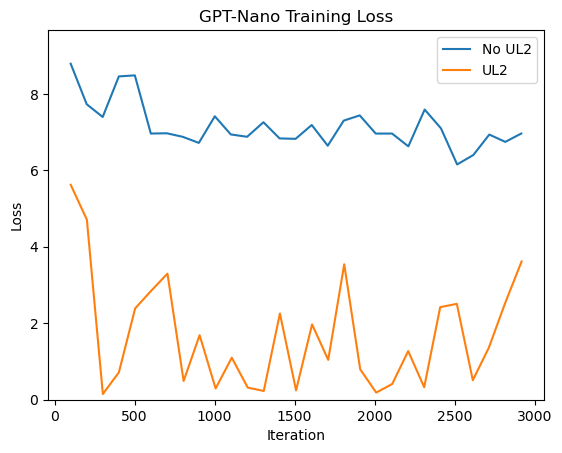

<Figure size 640x480 with 0 Axes>

In [105]:
# show loss
val1 = [a.detach().numpy() for a in trainer.saved_loss]
val2 = [a.detach().numpy() for a in trainer2.saved_loss]
# val2 = [a.detach().numpy() if a.detach().numpy() > 2 else a.detach().numpy() + 2 for a in trainer2.saved_loss]
# print(val1)
print(val2)
plt.plot(trainer.iter_list, val1, label="No UL2")
plt.plot(trainer2.iter_list, val2, label="UL2")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('GPT-Nano Training Loss')
plt.ylim(0, max(val1) *1.1)
plt.legend()
plt.show()

plt.savefig('gpt-nano-loss.png')

In [ ]:
# print the attributes of trainer
print(trainer.__dict__.keys())
print(trainer.iter_time)

dict_keys(['config', 'model', 'optimizer', 'train_dataset', 'callbacks', 'device', 'iter_num', 'iter_time', 'iter_dt'])
0.0


Use Model

In [ ]:
def generate(prompt="", sample_count=10, steps=20, do_sample=True):
    # handle empty prompt
    if prompt == "": prompt = "<|endoftext|>"
    
    # tokenize and encode the prompt in batches
    tokenizer = GPT2Tokenizer.from_pretrained(model_architecture)
    tokenized = tokenizer(prompt, return_tensors="pt").to(device)
    input = tokenized["input_ids"].expand(sample_count, -1)

    # generate output
    output = model.generate(input, max_new_tokens=steps, do_sample=do_sample, top_k=40)
    for i in range(sample_count):
        print(f"Sample {i+1}: {tokenizer.decode(output[i].cpu().squeeze(), skip_special_tokens=True)}\n")

In [ ]:
# generate("Math is")